In [1]:
from core import *
from utils import *
from diagnostics import *
from fields import *
from constants import *
from distributions import *

from scipy import constants as sp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import njit

import cProfile

def plot_traj(history):
    fig = plt.figure(figsize = plt.figaspect(1) * 7)
    ax = fig.add_subplot(111, projection='3d')

    for i in range(trials):
        pos = history[i, :, 0]
        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

    plt.show()
    
def plot_gca(gca):
    fig = plt.figure(figsize = plt.figaspect(1) * 7)
    ax = fig.add_subplot(111, projection='3d')

    for i in range(trials):
        pos = gca[i, :, :]
        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

    plt.show()
    
def to_percent(observed, actual):
    return abs((observed - actual) / actual) * 100

Load IGRF coefficients ...


In [2]:
e_field = zero_field() # uniform_field(1e-4, np.array([0., 1., 0.]))
b_field = t89(1)
solve   = solver(relativistic_boris(e_field, b_field))

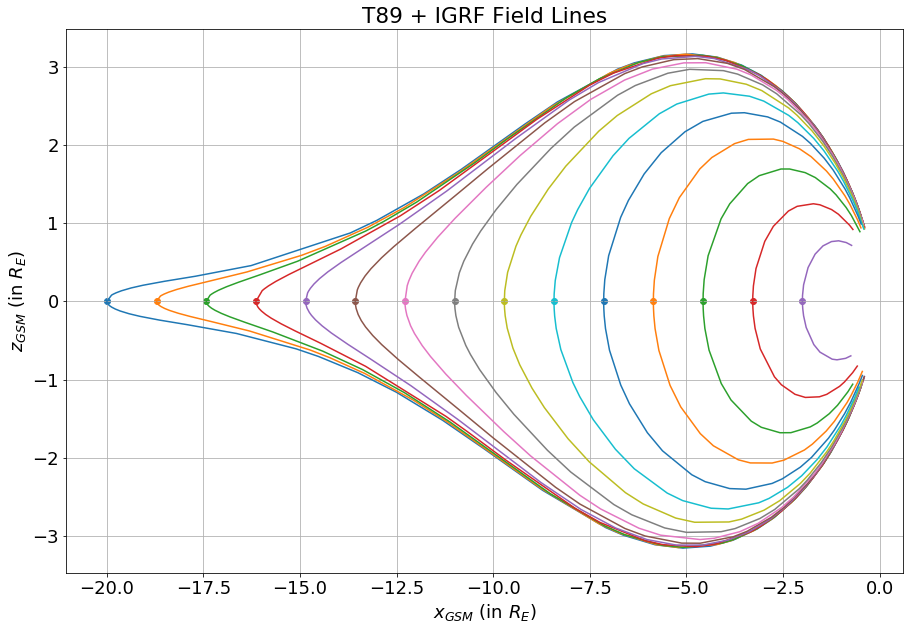

In [3]:
from field_utils import *

plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 18})

for i, x in enumerate(np.linspace(-20 * Re, -2 * Re, 15)):
    rr = field_line(b_field, np.array([x, 0, 0]), 1e1)
    r_min = field_reversal(b_field, rr)
    
    plt.plot(rr[:, 0] / Re, rr[:, 2] / Re)
    plt.scatter(r_min[0] / Re, r_min[2] / Re)
    
plt.grid()
plt.xlabel('$x_{GSM}$ (in $R_E$)')
plt.ylabel('$z_{GSM}$ (in $R_E$)')
plt.title('T89 + IGRF Field Lines')
plt.show()

In [97]:
T      = 1           # Total time (in seconds)
dt     = 1e-3        # Simulation time step
trials = 10000       # Number of runs
steps  = int(T / dt) # Number of steps per run

history, intrinsic = populate(trials,
                              steps,
                              e_field,
                              b_field,
                              delta(np.array([-12 * Re, 0., 0.])),
                              delta(1e6),
                              uniform(np.radians(0), np.radians(90)),
                              uniform(0, 2 * np.pi)
                             )

'''
history, intrinsic = populate_by_eq_pa(trials,
                                       steps,
                                       e_field,
                                       b_field,
                                       delta(12),                               # re/Re of field line
                                       delta(1e6),                              # Kinetic energy (eV)
                                       uniform(np.radians(0), np.radians(90)),  # Equatorial pitch angle
                                       uniform(0, 2 * np.pi)                    # Phase angle
                                      )
'''

solve(history, intrinsic, dt)

'''
eqpas = eq_pitch_angle_from_moment(history, intrinsic)

plt.figure(figsize=(15, 10))
for i in range(trials):
    plt.plot(np.arange(0, steps) * dt, eqpas[i])
    plt.grid()

plt.xlim([0, T])
plt.ylim([0, 90])
plt.grid()
plt.show()

plot_traj(history)
'''

'\neqpas = eq_pitch_angle_from_moment(history, intrinsic)\n\nplt.figure(figsize=(15, 10))\nfor i in range(trials):\n    plt.plot(np.arange(0, steps) * dt, eqpas[i])\n    plt.grid()\n\nplt.xlim([0, T])\nplt.ylim([0, 90])\nplt.grid()\nplt.show()\n\nplot_traj(history)\n'

In [5]:
plot = plotter(history, intrinsic, dt)

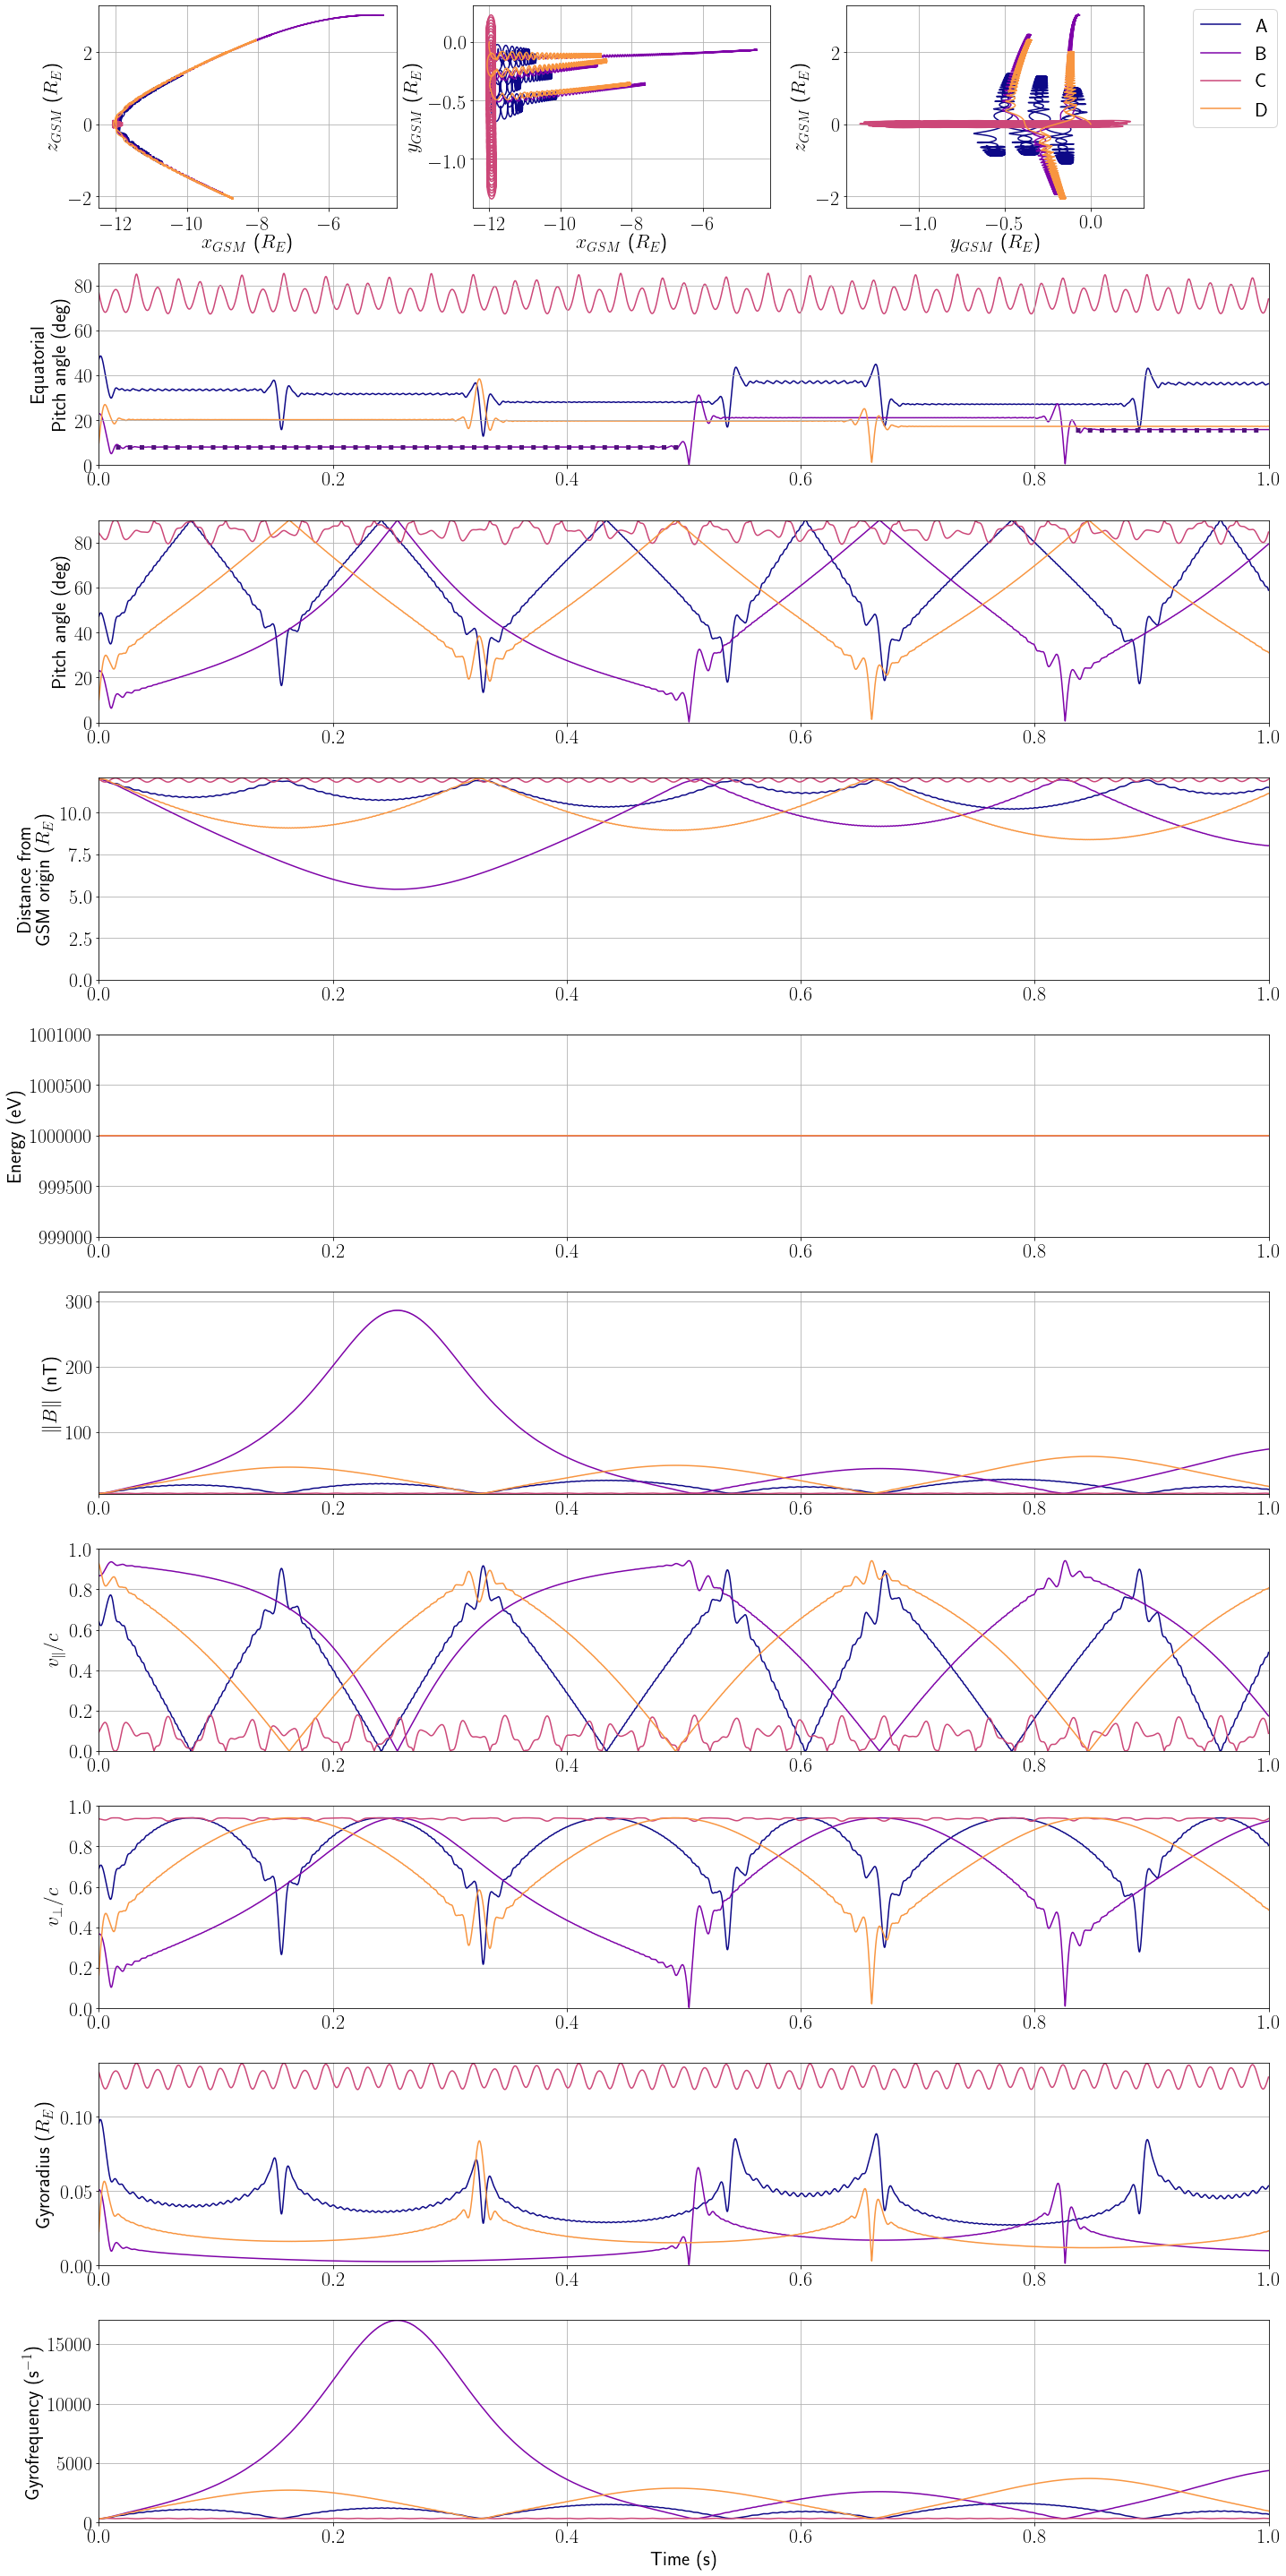

In [6]:
plot([1, 10, 7, 20])

In [98]:
def get_plane_distribution(history, intrinsic, x_gsm, dx = 0.01 * Re):
    num_particles = len(history[:, 0, 0, 0])
    steps         = len(history[0, :, 0, 0])
    
    plane_pos = x_gsm * Re
    p = position(history)
    
    indices_i = []
    indices_j = []
    
    for i in range(num_particles):
        for j in range(steps):
            if (p[i, j, 0] >= (plane_pos - dx)) and (p[i, j, 0] <= (plane_pos + dx)):
                indices_i.append(i)
                indices_j.append(j)
    
    return history[indices_i, indices_j, :, :], intrinsic[indices_i, :]

In [101]:
new_hist, new_intr = get_plane_distribution(history, intrinsic, -1.1)

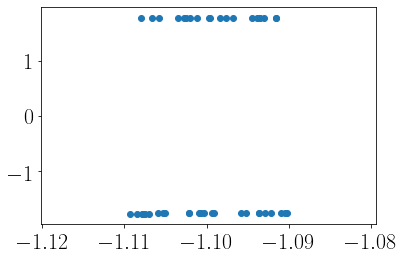

In [102]:
plt.scatter(new_hist[:, 0, 0] / Re, new_hist[:, 0, 2] / Re)

In [14]:
@njit
def diff_coef_inst(history):
    num_particles = len(history[:, 0, 0, 0])
    steps         = len(history[0, :, 0, 0])

    v                  = velocity(history)
    v_par, v_par_mag   = velocity_par(history)
    indices            = np.arange(0, steps) * dt

    mus = np.zeros((num_particles, steps - 1))
    D_uus = np.zeros((num_particles, steps - 1))

    for i in range(num_particles):
        for j in range(steps - 1):
            mu_0 = np.linalg.norm(v_par[i, j]) / np.linalg.norm(v[i, j])
            mu_1 = np.linalg.norm(v_par[i, j + 1]) / np.linalg.norm(v[i, j + 1])
            delta_mu = mu_1 - mu_0
            delta_t = indices[j + 1] - indices[j]

            mus[i, j] = delta_mu
            D_uus[i, j] = (delta_mu)**2 / (2 * delta_t)
            
    return mus, D_uus

In [68]:
@njit
def diff_coef_total(history):
    num_particles = len(history[:, 0, 0, 0])
    steps         = len(history[0, :, 0, 0])

    v                  = velocity(history)
    v_par, v_par_mag   = velocity_par(history)
    indices            = np.arange(0, steps) * dt

    mus = np.zeros((num_particles, steps - 1))
    D_uus = np.zeros((num_particles, steps - 1))

    for i in range(num_particles):
        mu_0 = np.linalg.norm(v_par[i, 0]) / np.linalg.norm(v[i, 0])
        for j in range(steps - 1):
            
            mu_1 = np.linalg.norm(v_par[i, j + 1]) / np.linalg.norm(v[i, j + 1])
            delta_mu = mu_1 - mu_0
            delta_t = indices[j + 1] - indices[0]

            mus[i, j] = delta_mu
            D_uus[i, j] = (delta_mu)**2 / (2 * delta_t)
            
    return mus, D_uus

In [69]:
mus_inst, D_uus_inst = diff_coef_inst(history)
mus_tot, D_uus_tot = diff_coef_total(history)

In [70]:
def compare_diff_coef(indices):
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(121)
    for i in indices:
        plt.hist(D_uus_inst[:, i], bins=20, histtype='step', density=True)

    plt.subplot(122)
    for i in indices:
        plt.hist(D_uus_tot[:, i], bins=20, histtype='step', density=True)

    plt.show()

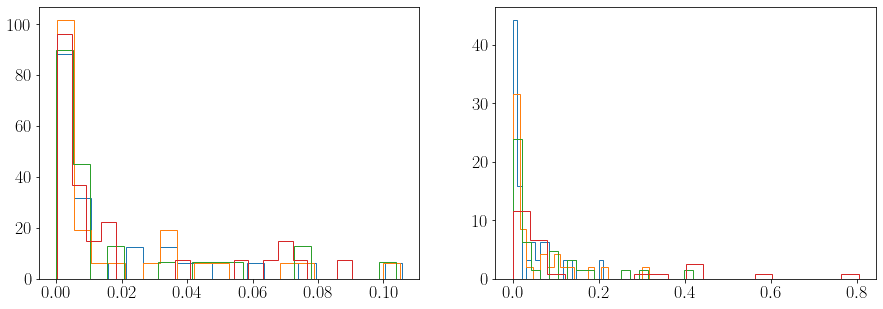

In [71]:
compare_diff_coef([1, 2, 3, 7])

In [44]:
p_mag = position_mag(history) / Re

In [48]:
np.argwhere(p_mag <= 0.1 * Re)

array([[   0,    0],
       [   0,    1],
       [   0,    2],
       ...,
       [9999,  997],
       [9999,  998],
       [9999,  999]])